# Climate Analysis


### Data Cleaning

In [1]:
import altair as alt
import pandas as pd
import numpy as np

In [2]:
# import data
df = pd.read_csv('data/Environment_Temperature_change_E_All_Data_NOFLAG.csv', encoding='latin-1')

In [3]:
df.head()

,Area Code,Area,Months Code,Months,Element Code,Element,Unit,Y1961,Y1962,Y1963,...,Y2010,Y2011,Y2012,Y2013,Y2014,Y2015,Y2016,Y2017,Y2018,Y2019
0,2,Afghanistan,7001,January,7271,Temperature change,°C,0.777,0.062,2.744,...,3.601,1.179,-0.583,1.233,1.755,1.943,3.416,1.201,1.996,2.951
1,2,Afghanistan,7001,January,6078,Standard Deviation,°C,1.950,1.950,1.950,...,1.950,1.950,1.950,1.950,1.950,1.950,1.950,1.950,1.950,1.950
2,2,Afghanistan,7002,February,7271,Temperature change,°C,-1.743,2.465,3.919,...,1.212,0.321,-3.201,1.494,-3.187,2.699,2.251,-0.323,2.705,0.086
3,2,Afghanistan,7002,February,6078,Standard Deviation,°C,2.597,2.597,2.597,...,2.597,2.597,2.597,2.597,2.597,2.597,2.597,2.597,2.597,2.597
4,2,Afghanistan,7003,March,7271,Temperature change,°C,0.516,1.336,0.403,...,3.390,0.748,-0.527,2.246,-0.076,-0.497,2.296,0.834,4.418,0.234


In [4]:
# Rename columns
df.columns = df.columns.str.lower().str.replace('y', '')

# Drop columns
df.drop(columns=['area code', 'months code', 'element code', 'unit'], inplace=True)

df['months'].unique()

array(['January', 'February', 'March', 'April', 'May', 'June', 'July',
       'August', 'September', 'October', 'November', 'December',
       'Dec\x96Jan\x96Feb', 'Mar\x96Apr\x96May', 'Jun\x96Jul\x96Aug',
       'Sep\x96Oct\x96Nov', 'Meteorological year'], dtype=object)

In [5]:
months_replace = {'Dec\x96Jan\x96Feb': 'quarter_1', 'Mar\x96Apr\x96May': 'quarter_2', 'Jun\x96Jul\x96Aug': 'quarter_3', 'Sep\x96Oct\x96Nov': 'quarter_4'}
df.replace(months_replace, inplace=True)

In [181]:
df.head()

,area,months,element,1961,1962,1963,1964,1965,1966,1967,...,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019
0,Afghanistan,January,Temperature change,0.777,0.062,2.744,-5.232,1.868,3.629,-1.432,...,3.601,1.179,-0.583,1.233,1.755,1.943,3.416,1.201,1.996,2.951
1,Afghanistan,January,Standard Deviation,1.950,1.950,1.950,1.950,1.950,1.950,1.950,...,1.950,1.950,1.950,1.950,1.950,1.950,1.950,1.950,1.950,1.950
2,Afghanistan,February,Temperature change,-1.743,2.465,3.919,-0.202,-0.096,3.397,0.296,...,1.212,0.321,-3.201,1.494,-3.187,2.699,2.251,-0.323,2.705,0.086
3,Afghanistan,February,Standard Deviation,2.597,2.597,2.597,2.597,2.597,2.597,2.597,...,2.597,2.597,2.597,2.597,2.597,2.597,2.597,2.597,2.597,2.597
4,Afghanistan,March,Temperature change,0.516,1.336,0.403,1.659,-0.909,-0.069,-0.759,...,3.390,0.748,-0.527,2.246,-0.076,-0.497,2.296,0.834,4.418,0.234


In [68]:
# Global temperature trend
global_temp = df.melt(var_name='year', value_name='temp', id_vars=('area', 'months', 'element'))

global_temp_grouped = global_temp.groupby(['area', 'element', 'year']).mean()
annual_temp_change = global_temp_grouped.pivot_table('temp', ['area', 'year'], 'element')
annual_temp_change.reset_index(drop=False, inplace=True)
annual_temp_change = annual_temp_change.rename_axis(None, axis=1)
annual_temp_change = annual_temp_change.rename(columns={'Standard Deviation': 'sd', 'Temperature change': 'mean_temp_change'})
annual_temp_change

,area,year,sd,mean_temp_change
0,Afghanistan,1961,1.187765,0.027941
1,Afghanistan,1962,1.187765,-0.197471
2,Afghanistan,1963,1.187765,0.888706
3,Afghanistan,1964,1.187765,-0.905647
4,Afghanistan,1965,1.187765,-0.051824
...,...,...,...,...
15138,Zimbabwe,2015,0.678353,1.209059
15139,Zimbabwe,2016,0.678353,1.205353
15140,Zimbabwe,2017,0.678353,0.237824
15141,Zimbabwe,2018,0.678353,0.532059


In [99]:
alt.data_transformers.enable('data_server')
alt.renderers.enable('mimetype')

# regions_bool = annual_temp_change.area.isin(['Africa',
#        'Eastern Africa', 'Middle Africa', 'Northern Africa',
#        'Southern Africa', 'Western Africa', 'Americas',
#        'Northern America', 'Central America', 'Caribbean',
#        'South America', 'Asia', 'Central Asia', 'Eastern Asia',
#        'Southern Asia', 'South-Eastern Asia', 'Western Asia', 'Europe',
#        'Eastern Europe', 'Northern Europe', 'Southern Europe',
#        'Western Europe', 'Oceania', 'Australia and New Zealand',
#        'Melanesia', 'Micronesia', 'Polynesia'])

regions_bool = annual_temp_change.area.isin(['Africa','Americas',
       'Asia', 'Europe','Oceania'])

region_temps = annual_temp_change[regions_bool]

,area,year,sd,mean_temp_change
4718,Europe,2007,0.788706,2.265529
4730,Europe,2019,0.788706,2.234765
4726,Europe,2015,0.788706,2.198706
4727,Europe,2016,0.788706,2.104059
4728,Europe,2017,0.788706,2.101294
4719,Europe,2008,0.788706,1.980824
4729,Europe,2018,0.788706,1.883706
4706,Europe,1995,0.788706,1.880765
4722,Europe,2011,0.788706,1.788412
4725,Europe,2014,0.788706,1.695824


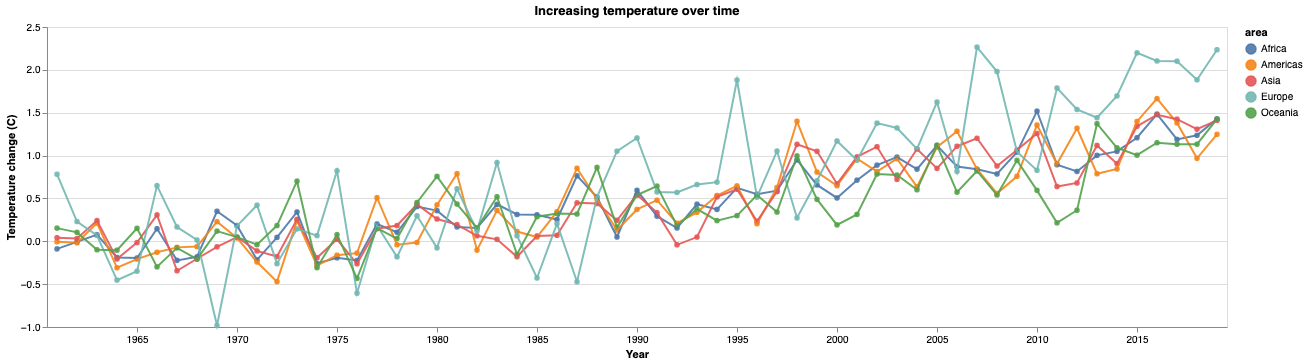

In [180]:
click = alt.selection_multi(fields=['area'], bind='legend')


scatter_plot = alt.Chart(region_temps, title="Increasing temperature over time"
                        ).mark_point(filled=True).encode(
    x=alt.X('year', title="Year", axis=alt.Axis(values=np.arange(1960, 2021, 5),  labelAngle=0)),
    y=alt.Y('mean(mean_temp_change)', title="Temperature change (C)") ,
    color='area',
    tooltip='area',
    opacity=alt.condition(click, alt.value(0.9), alt.value(0.2))
).add_selection(click)

line_plot = alt.Chart(region_temps).mark_line().encode(
    x='year',
    y='mean(mean_temp_change)',
    color='area',
    opacity=alt.condition(click, alt.value(0.9), alt.value(0.2))
)


scatter_plot + line_plot

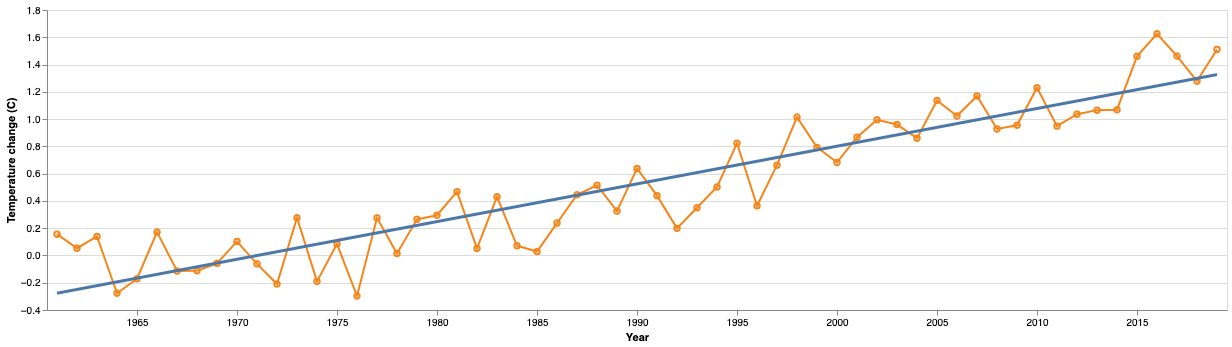

In [179]:
world_temp = annual_temp_change[annual_temp_change.area=='World']

world_plot.mark_errorband(extent='ci') + world_plot

world_plot = alt.Chart(world_temp).mark_point().encode(
    x=alt.X('year', title="Year", axis=alt.Axis(values=np.arange(1960, 2021, 5),  labelAngle=0)),
    y=alt.Y('mean(mean_temp_change)', title="Temperature change (C)") ,
    color=alt.Color('area', legend=None)
)

line_plot = alt.Chart(world_temp).mark_line().encode(
    x='year',
    y='mean(mean_temp_change)',
    color='area',
)

trend = world_plot.transform_regression(
    'year', 'mean_temp_change', groupby=['months']).mark_line(size=3)


world_plot + line_plot + trend